--- 1. Data Loading and Preprocessing ---


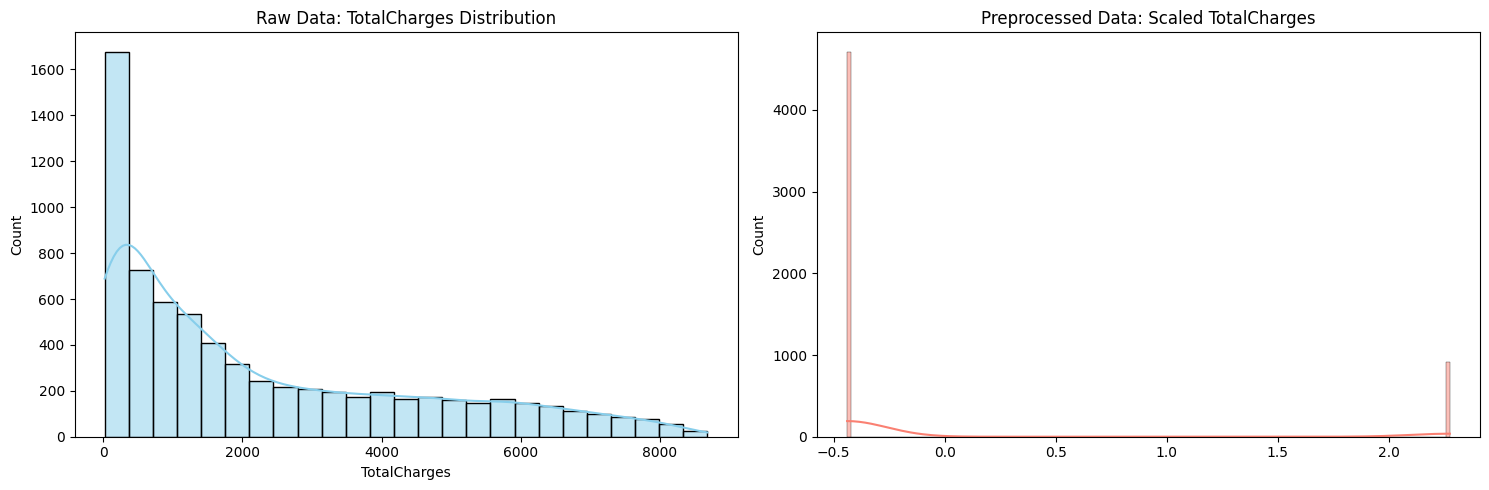


--- 2. Training and Hyperparameter Tuning ---
Training Logistic Regression...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Random Forest...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Deep Learning MLP...


C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\syedm\AppData\Roaming\Python\Python312\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



|                     |       F1 |   ROC AUC |   Accuracy |
|:--------------------|---------:|----------:|-----------:|
| Logistic Regression | 0.606925 |  0.835134 |   0.725657 |
| Random Forest       | 0.62037  |  0.832012 |   0.76688  |
| Deep Learning MLP   | 0.600595 |  0.833056 |   0.713575 |


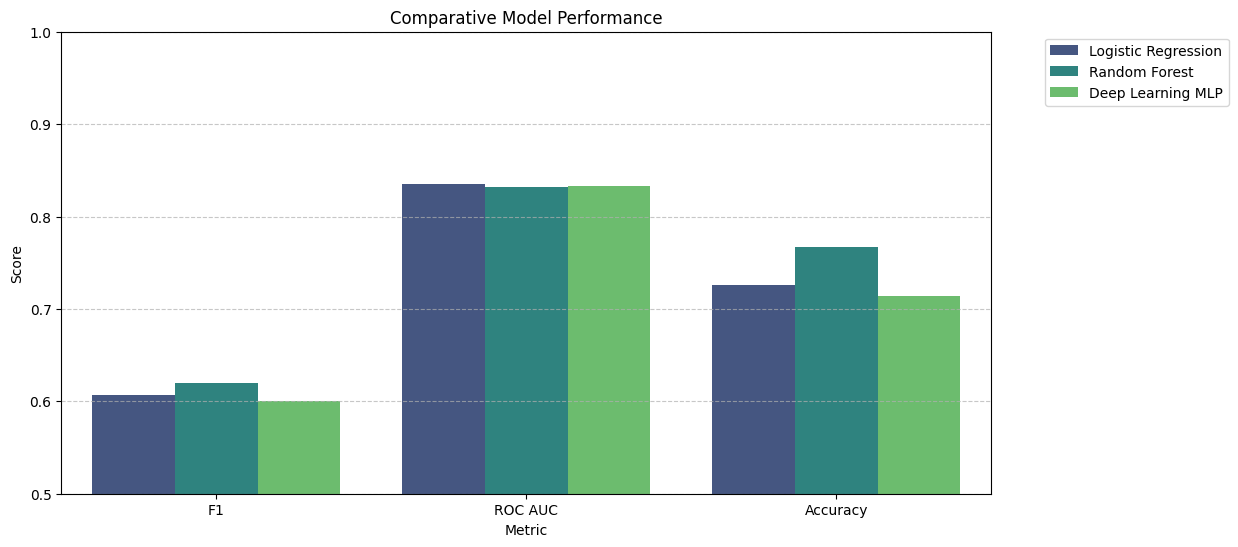

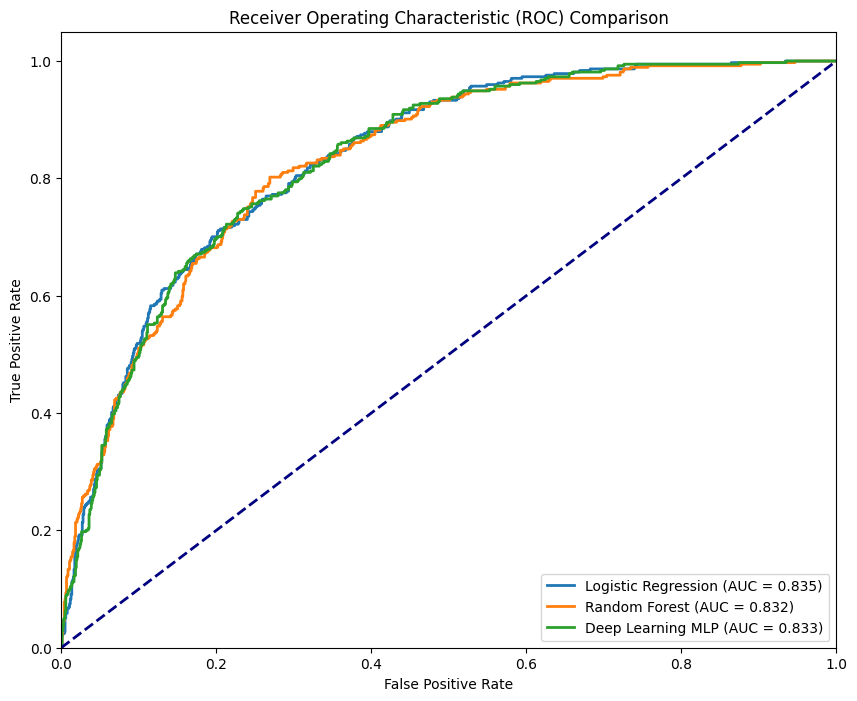

In [1]:
# ============================================================
# IMPORTING REQUIRED LIBRARIES
# ============================================================

# Pandas is used for data loading, cleaning, and manipulation
import pandas as pd

# NumPy provides numerical operations and array handling
import numpy as np

# Matplotlib is used for basic plotting and visualization
import matplotlib.pyplot as plt

# Seaborn is built on top of matplotlib and provides better-looking plots
import seaborn as sns

# ------------------------------------------------------------
# Scikit-learn imports for machine learning pipeline
# ------------------------------------------------------------

# Used to split dataset into training and testing sets
from sklearn.model_selection import train_test_split, GridSearchCV

# Used to normalize numerical features and encode categorical variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Used to apply different preprocessing steps to different feature types
from sklearn.compose import ColumnTransformer

# Pipeline ensures preprocessing and model training happen sequentially
from sklearn.pipeline import Pipeline

# Used to handle missing values
from sklearn.impute import SimpleImputer

# Random Forest model for non-linear ensemble learning
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression model for baseline linear classification
from sklearn.linear_model import LogisticRegression

# Evaluation metrics for classification performance
from sklearn.metrics import (
    accuracy_score,           # Measures overall correctness
    classification_report,    # Precision, recall, F1 per class
    f1_score,                 # Harmonic mean of precision and recall
    roc_auc_score,            # Area under ROC curve
    roc_curve,                # False Positive Rate vs True Positive Rate
    auc                       # Computes AUC from ROC curve
)

# Joblib is used to save trained models to disk
import joblib

# ------------------------------------------------------------
# PyTorch & Skorch imports for Deep Learning
# ------------------------------------------------------------

# Core PyTorch library
import torch

# PyTorch module for defining neural networks
import torch.nn as nn

# Optimization algorithms (Adam optimizer)
import torch.optim as optim

# Skorch wraps PyTorch models to behave like scikit-learn estimators
from skorch import NeuralNetClassifier

# ============================================================
# REPRODUCIBILITY SETTINGS
# ============================================================

# Fixed seed value to ensure reproducible results
SEED = 42

# Ensures NumPy operations give the same result every run
np.random.seed(SEED)

# Ensures PyTorch operations give the same result every run
torch.manual_seed(SEED)

# ============================================================
# 1. DATA LOADING AND INITIAL PREPROCESSING
# ============================================================

def load_and_preprocess_data():
    """
    Loads the Telco Customer Churn dataset and performs
    basic cleaning and target encoding.
    """

    # URL of the publicly available Telco Customer Churn dataset
    url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

    # Read CSV file into a Pandas DataFrame
    df = pd.read_csv(url)

    # Convert TotalCharges column to numeric
    # Non-numeric values are replaced with NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Drop customerID since it has no predictive value
    df = df.drop('customerID', axis=1)

    # Remove rows containing missing values
    df = df.dropna()

    # Convert target variable 'Churn' to binary format
    # Yes → 1 (Churned), No → 0 (Not churned)
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Return cleaned dataset
    return df

# ============================================================
# 2. FEATURE PREPROCESSING PIPELINE
# ============================================================

def create_preprocessing_pipeline(X):
    """
    Creates a preprocessing pipeline that:
    - Imputes missing values
    - Scales numerical features
    - One-hot encodes categorical features
    """

    # Identify categorical columns (object/string type)
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Identify numerical columns (int, float)
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

    # Pipeline for numerical features
    numerical_transformer = Pipeline(steps=[
        # Replace missing values with median
        ('imputer', SimpleImputer(strategy='median')),

        # Scale features to mean=0 and std=1
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        # Replace missing categorical values with 'missing'
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

        # Convert categories into binary vectors
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine numerical and categorical pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

# ============================================================
# 3. VISUALIZATION FUNCTIONS
# ============================================================

def visualize_data_transformation(df_raw, preprocessor, X_train):
    """
    Visualizes the impact of preprocessing by comparing
    raw and scaled versions of the TotalCharges feature.
    """

    # Apply preprocessing transformations to training data
    X_transformed = preprocessor.fit_transform(X_train)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot raw TotalCharges distribution
    sns.histplot(df_raw['TotalCharges'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Raw Data: TotalCharges Distribution')

    # Plot scaled TotalCharges distribution (first numerical column)
    sns.histplot(X_transformed[:, 0], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Preprocessed Data: Scaled TotalCharges')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display plots
    plt.show()

def plot_performance_metrics(results_df):
    """
    Creates a grouped bar chart comparing
    F1 Score, Accuracy, and ROC AUC for all models.
    """

    # Convert results DataFrame to long format for seaborn
    plot_df = results_df.reset_index().rename(columns={'index': 'Model'})
    plot_df = plot_df.melt(
        id_vars='Model',
        value_vars=['F1', 'ROC AUC', 'Accuracy'],
        var_name='Metric',
        value_name='Score'
    )

    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model', palette='viridis')

    # Chart formatting
    plt.title('Comparative Model Performance')
    plt.ylim(0.5, 1.0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display plot
    plt.show()

def plot_all_roc_curves(roc_data, y_test):
    """
    Plots ROC curves for all trained models on a single graph
    to visually compare their classification performance.
    """

    plt.figure(figsize=(10, 8))

    # Loop through each model's predicted probabilities
    for model_name, y_prob in roc_data.items():
        # Compute False Positive Rate and True Positive Rate
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        # Compute Area Under Curve
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Plot reference diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Axis labels and limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Comparison')

    # Legend placement
    plt.legend(loc="lower right")

    # Display plot
    plt.show()

# ============================================================
# 4. DEEP LEARNING MODEL DEFINITION
# ============================================================

class ChurnMLP(nn.Module):
    """
    Multilayer Perceptron (MLP) for binary churn prediction.
    """

    def __init__(self, num_features=None, num_units=100, dropout_rate=0.5):
        super().__init__()

        # Default feature size if not explicitly provided
        if num_features is None:
            num_features = 30

        # First fully connected layer
        self.layer1 = nn.Linear(num_features, num_units)

        # Dropout layer to reduce overfitting
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second fully connected layer with reduced neurons
        self.layer2 = nn.Linear(num_units, num_units // 2)

        # Second dropout layer
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer producing a single logit
        self.layer3 = nn.Linear(num_units // 2, 1)

    def forward(self, X):
        # Ensure input tensor is float type
        X = X.float()

        # Forward pass through first layer
        X = torch.relu(self.layer1(X))
        X = self.dropout1(X)

        # Forward pass through second layer
        X = torch.relu(self.layer2(X))
        X = self.dropout2(X)

        # Output raw logit (used with BCEWithLogitsLoss)
        return self.layer3(X)

# ============================================================
# 5. MAIN EXECUTION FUNCTION
# ============================================================

def main_with_viz():
    print("--- 1. Data Loading and Preprocessing ---")

    # Load and clean dataset
    df = load_and_preprocess_data()

    # Separate features and target variable
    X = df.drop('Churn', axis=1)
    y = df['Churn'].values.astype(np.float32).reshape(-1, 1)

    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(X)

    # Visualize effect of preprocessing
    visualize_data_transformation(df, preprocessor, X_train)

    # Apply preprocessing to determine number of features
    X_train_processed = preprocessor.fit_transform(X_train)
    num_features = X_train_processed.shape[1]

    # Calculate class weights to handle imbalance
    neg_count = np.sum(y_train == 0)
    pos_count = np.sum(y_train == 1)
    pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32)

    # Initialize deep learning model using Skorch
    dl_model = NeuralNetClassifier(
        ChurnMLP,
        module__num_features=num_features,
        criterion=nn.BCEWithLogitsLoss,
        optimizer=optim.Adam,
        max_epochs=20,
        iterator_train__shuffle=True,
        verbose=0,
        criterion__pos_weight=pos_weight
    )

    # Define models and hyperparameters
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=1000),
            'params': {'classifier__C': [0.1, 1, 10]}
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=SEED, class_weight='balanced'),
            'params': {'classifier__n_estimators': [100], 'classifier__max_depth': [10]}
        },
        'Deep Learning MLP': {
            'model': dl_model,
            'params': {
                'classifier__module__num_units': [50, 100],
                'classifier__lr': [0.001]
            }
        }
    }

    # Dictionaries to store evaluation results
    results = {}
    roc_curves_data = {}
    y_test_flat = y_test.ravel()

    print("\n--- 2. Training and Hyperparameter Tuning ---")

    # Train and evaluate each model
    for model_name, model_info in models.items():
        print(f"Training {model_name}...")

        # Create end-to-end pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_info['model'])
        ])

        # GridSearch for hyperparameter tuning
        grid_search = GridSearchCV(
            pipeline,
            model_info['params'],
            cv=3,
            scoring='f1',
            n_jobs=-1
        )

        # Train model
        grid_search.fit(X_train, y_train)

        # Predict class labels
        y_pred = grid_search.predict(X_test)

        # Predict probabilities for ROC analysis
        if hasattr(grid_search.best_estimator_.named_steps['classifier'], 'predict_proba'):
            y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = grid_search.best_estimator_.predict_proba(X_test).ravel()

        # Store probabilities
        roc_curves_data[model_name] = y_pred_proba

        # Store evaluation metrics
        results[model_name] = {
            'F1': f1_score(y_test_flat, y_pred),
            'ROC AUC': roc_auc_score(y_test_flat, y_pred_proba),
            'Accuracy': accuracy_score(y_test_flat, y_pred)
        }

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results).T
    print("\n" + results_df.to_markdown())

    # Plot comparisons
    plot_performance_metrics(results_df)
    plot_all_roc_curves(roc_curves_data, y_test_flat)

# ============================================================
# PROGRAM ENTRY POINT
# ============================================================

# Ensures the script runs only when executed directly
if __name__ == "__main__":
    main_with_viz()
